In [19]:
import os
import sys
import igl
import torch
import trimesh
import subprocess
import numpy as np 
import pandas as pd
import open3d as o3d
import shapeworks as sw
import meshplot as mp
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from scipy.stats import pearsonr
from ipywidgets import interact, widgets
from sklearn.decomposition import PCA, KernelPCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cross_decomposition import PLSRegression
from pyopls import OPLS

sys.path.append('../../../utils/')
from sap_score import sap
# from spca import SPCA

# Load train val test files

In [2]:
train_val_test = torch.load("../../DeepLearning/hippocampus/098eadecec5245c6a06e531bc3c33c64/artifacts/train_val_test_files.pt")
train_files = train_val_test['train']
test_files = train_val_test['test']
val_files = train_val_test['val']

# Load Labels

In [3]:
df = pd.read_csv("demographics.csv", delimiter=";")

train_ages = []
train_sex = []
val_ages = []
val_sex = []

for subject in val_files:
    val_ages.append(df[df.subject == subject].age.item())
    val_sex.append(df[df.subject == subject].gender.item())
val_ages = np.array(val_ages).reshape(-1,1)
val_sex = pd.Series(val_sex, dtype="category").cat.codes.values.reshape(-1,1)  #male=1 female=0

for subject in train_files:
    train_ages.append(df[df.subject == subject].age.item())
    train_sex.append(df[df.subject == subject].gender.item())
train_ages = np.array(train_ages).reshape(-1,1)
train_sex = pd.Series(train_sex, dtype="category").cat.codes.values.reshape(-1,1)  #male=1 female=0

In [48]:
# conditional = False

# if conditional:
#     labels = torch.load("labels.pt")
#     df = pd.DataFrame(labels).transpose()
#     subjects = df.index.to_list()
#     volumes = df.Volume.to_numpy()
#     ages = df.Age.to_numpy()
# else:
#     ages = []
#     ages_val = []
#     df = pd.read_csv("demographics.csv", delimiter=";")
#     subjects = df.subject.to_list()
#     for idx, subject in tqdm(enumerate(subjects)):
#         if subject in train_files:
#             ages.append(df.age.iloc[idx])
#             # ages = df.age.to_numpy()
#         if subject in val_files:
#             ages_val.append(df.age.iloc[idx])
    
#     ages = np.array(ages)
#     ages_val = np.array(ages_val)

510it [00:00, 45046.86it/s]


In [4]:
# from sklearn.utils.validation import check_is_fitted
# from sklearn.utils import check_array, check_X_y

# def inverse_transform(lda, x):
#     if lda.solver == 'lsqr':
#         raise NotImplementedError("(inverse) transform not implemented for 'lsqr' "
#                                   "solver (use 'svd' or 'eigen').")
#     check_is_fitted(lda, ['xbar_', 'scalings_'], all_or_any=any)

#     inv = np.linalg.pinv(lda.scalings_)[:16]

#     x = check_array(x)
#     if lda.solver == 'svd':
#         x_back = np.dot(x, inv) + lda.xbar_
#     elif lda.solver == 'eigen':
#         x_back = np.dot(x, inv)

#     return x_back

In [5]:
# df = pd.read_csv("demographics.csv", delimiter=";")

# files = glob("data/*.nii")

# filenames = []
# for filename in files:
#     filename = filename.split("\\")[-1].replace("_standard.nii", "")
#     filenames.append(filename)
    
# for filename in filenames:
#     if not filename in df.subject.to_list():
#         print(f"There is no label for: {filename}")

# df[df.subject == "ab300_257"]

## Load meshes

In [4]:
#left original meshes
mesh_list = []
for mesh_path in tqdm(sorted(glob("groomed/*left.vtk"))):
    name = mesh_path.split("\\")[-1].replace("_left.vtk", "")
    if not name in val_files:
        continue
    else:
        mesh_list.append(sw.Mesh(mesh_path))
        
#right original meshes
right_mesh_list = []
for mesh_path in tqdm(sorted(glob("groomed/*right.vtk"))):
    name = mesh_path.split("\\")[-1].replace("_right.vtk", "")
    if not name in val_files:
        continue
    else:
        right_mesh_list.append(sw.Mesh(mesh_path))   

100%|█████████████████████████████████████████████| 511/511 [00:01<00:00, 332.42it/s]


## Select ShapeWorks Model

In [21]:
num_particles = 2048

## Left hippocampus particles

In [6]:
# # left particles
# particles_list = []
# particles_list_val = []

# for particles_path in tqdm(glob(f"shape_model_{num_particles}/hippocampus_particles/*left_world.particles")):
#     name = particles_path.split("\\")[-1].replace("_left_world.particles","")
#     if name in train_files:
#         particles_list.append(sw.ParticleSystem([particles_path]).ShapeAsPointSet(0).flatten())    
#     elif name in val_files:
#         particles_list_val.append(sw.ParticleSystem([particles_path]).ShapeAsPointSet(0).flatten())
#     else:
#         continue        
    
# particles_array = np.array(particles_list)
# particles_array_val = np.array(particles_list_val)

## Right hippocampus particles

In [7]:
# # right particles
# right_particles_list = []
# right_particles_list_val = []

# for particles_path in tqdm(glob(f"shape_model_{num_particles}/hippocampus_particles/*right_world.particles")):
#     name = particles_path.split("\\")[-1].replace("_right_world.particles","")
#     if name in train_files:
#         right_particles_list.append(sw.ParticleSystem([particles_path]).ShapeAsPointSet(0).flatten()) 
#     elif name in val_files:
#         right_particles_list_val.append(sw.ParticleSystem([particles_path]).ShapeAsPointSet(0).flatten())
#     else:
#         continue            
    
# right_particles_array = np.array(right_particles_list)
# right_particles_array_val = np.array(right_particles_list_val)

## Left hippocampus PCA

In [8]:
# pca = PCA(n_components=16)
# pca.fit(particles_array)
# pca_latent = pca.transform(particles_array_val)

# exp_var_pca = pca.explained_variance_ratio_
# cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# plt.figure(figsize=(10,5))
# plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
# plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
# plt.ylabel('Explained variance ratio')
# plt.xlabel('Principal component index')
# plt.legend(loc='center right')
# plt.title("Left Hippocampi")
# plt.tight_layout()
# plt.savefig("../figures/left_hippo.png")
# plt.show()

# # plt.rcParams["figure.figsize"] = [12, 6]
# # f, ax = plt.subplots()
# # points = ax.scatter(pca_latent[:,0], pca_latent[:,1], c=df.age.tolist(), cmap="plasma")
# # f.colorbar(points)
# # plt.title("PCA")
# # plt.show()

## Left hippocampus LDA

In [9]:
# lda = LinearDiscriminantAnalysis(n_components=16)
# lda.fit(particles_array, df.age.to_numpy().reshape(-1, 1))
# lda_latent = lda.transform(particles_array)
# #recon_particles = inverse_transform(lda, lda_latent)

# plt.rcParams["figure.figsize"] = [12, 6]
# f, ax = plt.subplots()
# points = ax.scatter(lda_latent[:,0], lda_latent[:,1], c=df.age.tolist(), cmap="plasma")
# f.colorbar(points)
# plt.title("LDA")
# plt.show()

## Left hippocampus PLS

In [10]:
# # opls = OPLS(n_components=50)
# # opls_latent = opls.fit_transform(particles_array, df.age.to_numpy().reshape(-1, 1))

# pls = PLSRegression(n_components=16)
# pls.fit(particles_array, df.age.to_numpy().reshape(-1, 1))
# pls_latent = pls.transform(particles_array)
# print(pls.score(particles_array, df.age.to_numpy().reshape(-1, 1)))

# plt.rcParams["figure.figsize"] = [12, 6]
# f, ax = plt.subplots()
# points = ax.scatter(pls_latent[:,0], pls_latent[:,1], c=df.age.tolist(), cmap="plasma")
# f.colorbar(points)
# plt.title("PLS")
# plt.show()

## Left hippocampus OPLS

In [11]:
# df.age.to_numpy().reshape(-1, 1).shape

In [12]:
# opls = OPLS()
# opls_latent = opls.fit_transform(particles_array, df.age.to_numpy().reshape(-1, 1))
# #opls_latent = opls.transform(particles_array)

In [13]:
# opls.score(particles_array)

## Left hippocampus Kernel PCA

In [14]:
# pca = KernelPCA(n_components=16, fit_inverse_transform=True)
# pca.fit(particles_array, df.age.to_numpy().reshape(-1, 1))
# pca_latent = pca.transform(particles_array)

# exp_var_pca = pca.explained_variance_ratio_
# cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# plt.figure(figsize=(10,5))
# plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
# plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
# plt.ylabel('Explained variance ratio')
# plt.xlabel('Principal component index')
# plt.legend(loc='center right')
# plt.title("Left Hippocampi")
# plt.tight_layout()
# plt.savefig("figures/left_hippo.png")
# plt.show()

## Right hippocampus PCA

In [15]:
# right_pca = PCA(n_components=32)
# right_pca.fit(right_particles_array)
# right_pca_latent = right_pca.transform(right_particles_array_val)

# right_exp_var_pca = right_pca.explained_variance_ratio_
# right_cum_sum_eigenvalues = np.cumsum(right_exp_var_pca)

# plt.figure(figsize=(10,5))
# plt.bar(range(0,len(right_exp_var_pca)), right_exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
# plt.step(range(0,len(right_cum_sum_eigenvalues)), right_cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
# plt.ylabel('Explained variance ratio')
# plt.xlabel('Principal component index')
# plt.legend(loc='center right')
# plt.title("Right Hippocampi")
# plt.tight_layout()
# plt.savefig("../figures/right_hippo.png")
# plt.show()

## Right hippocampus LDA

In [16]:
# right_lda = LinearDiscriminantAnalysis(n_components=16)
# right_lda.fit(right_particles_array, df.age.to_numpy().reshape(-1, 1))
# right_lda_latent = right_lda.transform(right_particles_array)
# #recon_particles = inverse_transform(lda, lda_latent)

## Right hippocampus Kernel PCA

In [17]:
# right_pca = KernelPCA(n_components=16, fit_inverse_transform=True)
# right_pca.fit(right_particles_array,  df.age.to_numpy().reshape(-1, 1))
# right_pca_latent = right_pca.transform(right_particles_array)

# right_exp_var_pca = right_pca.explained_variance_ratio_
# right_cum_sum_eigenvalues = np.cumsum(right_exp_var_pca)

# plt.figure(figsize=(10,5))
# plt.bar(range(0,len(right_exp_var_pca)), right_exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
# plt.step(range(0,len(right_cum_sum_eigenvalues)), right_cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
# plt.ylabel('Explained variance ratio')
# plt.xlabel('Principal component index')
# plt.legend(loc='center right')
# plt.title("Right Hippocampi")
# plt.tight_layout()
# plt.savefig("figures/right_hippo.png")
# plt.show()

In [99]:
# left particles
particles_list = []
particles_list_val = []

for particles_path in tqdm(sorted(glob(f"shape_model_{num_particles}/hippocampus_particles/*left_local.particles"))):
    name = particles_path.split("\\")[-1].replace("_left_local.particles","")
    if name in train_files:
        particles_list.append(sw.ParticleSystem([particles_path]).ShapeAsPointSet(0).flatten())    
    elif name in val_files:
        particles_list_val.append(sw.ParticleSystem([particles_path]).ShapeAsPointSet(0).flatten())
    else:
        continue        

particles_array = np.array(particles_list)
particles_array_val = np.array(particles_list_val)    

warper = sw.MeshWarper()
warper.generateWarp(mesh_list[0], particles_array_val[0].reshape(num_particles, 3))

# right particles
right_particles_list = []
right_particles_list_val = []

for particles_path in tqdm(sorted(glob(f"shape_model_{num_particles}/hippocampus_particles/*right_local.particles"))):
    name = particles_path.split("\\")[-1].replace("_right_local.particles","")
    if name in train_files:
        right_particles_list.append(sw.ParticleSystem([particles_path]).ShapeAsPointSet(0).flatten()) 
    elif name in val_files:
        right_particles_list_val.append(sw.ParticleSystem([particles_path]).ShapeAsPointSet(0).flatten())
    else:
        continue            

right_particles_array = np.array(right_particles_list)
right_particles_array_val = np.array(right_particles_list_val)

right_warper = sw.MeshWarper()
right_warper.generateWarp(right_mesh_list[0], right_particles_array_val[0].reshape(num_particles, 3))

# concatenate left & right particles
particles_array = np.concatenate([particles_array, right_particles_array], axis=1)

scaler = StandardScaler()
scaler.fit(particles_array)
particles_array = scaler.transform(particles_array)
print(np.max(particles_array))

particles_array_val = np.concatenate([particles_array_val, right_particles_array_val], axis=1)
particles_array_val = scaler.transform(particles_array_val)
print(np.max(particles_array_val))

100%|█████████████████████████████████████████████| 511/511 [00:03<00:00, 130.38it/s]


4.68102936615589
5.247290978140737


In [111]:
pca = PCA(n_components=16)
pca.fit(particles_array)
pca_latent = pca.transform(particles_array_val)

mean_latent = np.mean(pca_latent, axis=0)
std_latent = np.std(pca_latent, axis=0)

mean_recon = pca.inverse_transform(mean_latent)
mean_recon = scaler.inverse_transform(mean_recon.reshape(1,-1))
mean_left = mean_recon[:, :num_particles*3].reshape(num_particles, 3)
mean_right = mean_recon[:, num_particles*3:].reshape(num_particles, 3)

mean_left = warper.buildMesh(mean_left)
mean_right = right_warper.buildMesh(mean_right)

p = mp.plot(mean_left.points(), mean_left.faces())
p.add_mesh(mean_right.points(), mean_right.faces())

@interact(z0=widgets.FloatSlider(value=mean_latent[0], min=-3*std_latent[0], max=3*std_latent[0], step=0.01),
          z1=widgets.FloatSlider(value=mean_latent[1], min=-3*std_latent[1], max=3*std_latent[1], step=0.01),
          z2=widgets.FloatSlider(value=mean_latent[2], min=-3*std_latent[2], max=3*std_latent[2], step=0.01),
          z3=widgets.FloatSlider(value=mean_latent[3], min=-3*std_latent[3], max=3*std_latent[3], step=0.01))
def visualize(z0, z1, z2, z3):
    
    latent_code = mean_latent
    latent_code[0] = z0
    latent_code[0] = z1
    latent_code[0] = z2
    latent_code[0] = z3
    
    reconstruction = pca.inverse_transform(latent_code)
    reconstruction = scaler.inverse_transform(reconstruction.reshape(1,-1))
    recon_left = reconstruction[:, :num_particles*3].reshape(num_particles, 3)
    recon_right = reconstruction[:, num_particles*3:].reshape(num_particles, 3)
    
    recon_left = warper.buildMesh(recon_left)
    recon_right = right_warper.buildMesh(recon_right)
    
    p.update_object(oid=0, vertices=recon_left.points(), faces=recon_left.faces())
    p.update_object(oid=1, vertices=recon_right.points(), faces=recon_right.faces())
    
    
    
    

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(90.027854…

interactive(children=(FloatSlider(value=-1.1542541246982438, description='z0', max=226.66451680700746, min=-22…

## Latent traversal

In [22]:
maps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
shading = {"colormap": maps[1]}

In [39]:
hippo_shape = 1

#left
original_mesh = mesh_list[hippo_shape]
# particles = sorted(glob(f"shape_model_{num_particles}/hippocampus_particles/*left_local.particles"))
# original_particles = sw.ParticleSystem([particles[hippo_shape]]).ShapeAsPointSet(0)
# original_particles = particles_list_val[hippo_shape].reshape(num_particles, -1)

particles_list = []
particles_list_val = []

for particles_path in tqdm(glob(f"shape_model_{num_particles}/hippocampus_particles/*left_local.particles")):
    name = particles_path.split("\\")[-1].replace("_left_local.particles","")
    if name in train_files:
        particles_list.append(sw.ParticleSystem([particles_path]).ShapeAsPointSet(0))    
    elif name in val_files:
        particles_list_val.append(sw.ParticleSystem([particles_path]).ShapeAsPointSet(0))
    else:
        continue  
original_particles = particles_list_val[hippo_shape]
        
#right
right_original_mesh = right_mesh_list[hippo_shape]
# right_particles = sorted(glob(f"shape_model_{num_particles}/hippocampus_particles/*right_local.particles"))
# right_original_particles = sw.ParticleSystem([right_particles[hippo_shape]]).ShapeAsPointSet(0)
# right_original_particles = right_particles_list_val[hippo_shape].reshape(num_particles, -1)

right_particles_list = []
right_particles_list_val = []

for particles_path in tqdm(glob(f"shape_model_{num_particles}/hippocampus_particles/*right_local.particles")):
    name = particles_path.split("\\")[-1].replace("_right_local.particles","")
    if name in train_files:
        right_particles_list.append(sw.ParticleSystem([particles_path]).ShapeAsPointSet(0)) 
    elif name in val_files:
        right_particles_list_val.append(sw.ParticleSystem([particles_path]).ShapeAsPointSet(0))
    else:
        continue 
        
right_original_particles = right_particles_list_val[hippo_shape]

#left
warper = sw.MeshWarper()
warper.generateWarp(original_mesh, original_particles)
warped_mesh = warper.buildMesh(original_particles)

#right
right_warper = sw.MeshWarper()
right_warper.generateWarp(right_original_mesh, right_original_particles)
right_warped_mesh = right_warper.buildMesh(right_original_particles)

###### Mean Shape - Begin#####
#left
mean_mesh = sw.Mesh("shape_model_256/left_mean_hippocampus.ply")
mean_particles = pca.inverse_transform(np.zeros(32)).reshape(-1, 3)
warper = sw.MeshWarper()
warper.generateWarp(mean_mesh, mean_particles)
warped_mean_mesh = warper.buildMesh(mean_particles)

#right
right_mean_mesh = sw.Mesh("shape_model_256/right_mean_hippocampus.ply")
right_mean_particles = right_pca.inverse_transform(np.zeros(32)).reshape(-1, 3)
right_warper = sw.MeshWarper()
right_warper.generateWarp(right_mean_mesh, right_mean_particles)
right_warped_mean_mesh = right_warper.buildMesh(right_mean_particles)

###### Mean Shape - End#####

p = mp.plot(warped_mean_mesh.points(), warped_mean_mesh.faces(), shading=shading)
p.add_mesh(right_warped_mean_mesh.points(), right_warped_mean_mesh.faces(), shading=shading)

std_0 = pca_latent[:,0].std()
std_1 = pca_latent[:,1].std()
std_2 = pca_latent[:,2].std()
std_3 = pca_latent[:,3].std()

@interact(z0=widgets.FloatSlider(value=pca_latent[hippo_shape][0], min=-3*std_0, max=3*std_0, step=0.01),
          z1=widgets.FloatSlider(value=pca_latent[hippo_shape][1], min=-3*std_1, max=3*std_1, step=0.01),
          z2=widgets.FloatSlider(value=pca_latent[hippo_shape][2], min=-3*std_2, max=3*std_2, step=0.01),
          z3=widgets.FloatSlider(value=pca_latent[hippo_shape][3], min=-3*std_3, max=3*std_3, step=0.01))
def visualize(z0, z1, z2, z3):
    latent_code = pca_latent[hippo_shape]
    right_latent_code = right_pca_latent[hippo_shape]
    
    #left
    latent_code[0] = z0
    latent_code[1] = z1
    latent_code[2] = z2
    latent_code[3] = z3
    latent_code[:] = 0
    latent_code[1] = z1
    
    
    #right
    right_latent_code[0] = z0
    right_latent_code[1] = -z1
    right_latent_code[2] = z2
    right_latent_code[3] = z3
    right_latent_code[:] = 0
    right_latent_code[1] = -z1
        
    
    #left mesh warp
    recon_particles = pca.inverse_transform(latent_code.reshape(1,-1)).reshape(-1,3)
    recon_mesh = warper.buildMesh(recon_particles)
    recon_mesh.points()
    recon_mesh.faces()
    igl.write_triangle_mesh("left_mean.ply", v=recon_mesh.points(), f=recon_mesh.faces())
    
    #right mesh warp
    right_recon_particles = right_pca.inverse_transform(right_latent_code.reshape(1,-1)).reshape(-1,3)
    right_recon_mesh = right_warper.buildMesh(right_recon_particles)
    right_recon_mesh.points()
    right_recon_mesh.faces()
    igl.write_triangle_mesh("right_mean.ply", v=right_recon_mesh.points(), f=right_recon_mesh.faces())
    
    #left distance
    diff = warped_mean_mesh.points() - recon_mesh.points()
    dist = np.linalg.norm(diff, axis=1)
    print(f"Max distance: {np.max(dist)}")
    
    #right distance
    right_diff = right_warped_mean_mesh.points() - right_recon_mesh.points()
    right_dist = np.linalg.norm(right_diff, axis=1)
    
    mesh = trimesh.Trimesh(recon_mesh.points(), warped_mesh.faces())
    print(f"Volume: {mesh.volume:.2f}")
    
    #left
    p.update_object(oid=0, vertices=recon_mesh.points(), colors=dist)
    
    #right
    p.update_object(oid=1, vertices=right_recon_mesh.points(), colors=right_dist)
    
    #print(latent_code)
    #print(right_latent_code)

100%|██████████████████████████████████████████████████████████████████████████████| 511/511 [00:00<00:00, 1895.28it/s]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(91.043796…

interactive(children=(FloatSlider(value=0.0, description='z0', max=37.41276906126786, min=-37.41276906126786, …

## Left hippocampus SAP & Correlation

In [13]:
# factors = df.age.to_numpy().reshape(-1,1)
# factors = ages.reshape(-1,1)
factors = val_ages
codes = pca_latent
print(f"SAP score: {sap(factors, codes):.4f}")
correlation_list = []
for i in range(pca_latent.shape[1]):
    correlation_list.append(pearsonr(factors.reshape(-1), codes[:,i])[0])
    print(f"Correlation of age and latent code {i}: {correlation_list[i]:.4f}")

correlations = abs(np.array(correlation_list))
print(f"Max Correlation: {np.max(correlations):.4f}")
print(f"Max Correlation Variable: {np.argmax(correlations):.4f}")

SAP score: 0.0329
Correlation of age and latent code 0: -0.0176
Correlation of age and latent code 1: -0.2974
Correlation of age and latent code 2: 0.0772
Correlation of age and latent code 3: 0.1009
Correlation of age and latent code 4: -0.1581
Correlation of age and latent code 5: -0.0974
Correlation of age and latent code 6: 0.1461
Correlation of age and latent code 7: 0.0718
Correlation of age and latent code 8: 0.1295
Correlation of age and latent code 9: -0.0978
Correlation of age and latent code 10: -0.0480
Correlation of age and latent code 11: -0.0673
Correlation of age and latent code 12: 0.0860
Correlation of age and latent code 13: -0.2357
Correlation of age and latent code 14: -0.0164
Correlation of age and latent code 15: 0.1997
Correlation of age and latent code 16: 0.0764
Correlation of age and latent code 17: 0.0300
Correlation of age and latent code 18: 0.0764
Correlation of age and latent code 19: 0.0862
Correlation of age and latent code 20: 0.0044
Correlation of ag

## Right hippocampus SAP & Correlation

In [53]:
# factors = df.age.to_numpy().reshape(-1,1)
factors = ages.reshape(-1,1)
right_codes = right_pca_latent
print(f"SAP score: {sap(factors, right_codes):.4f}")
correlation_list = []
for i in range(pca_latent.shape[1]):
    correlation_list.append(pearsonr(factors.reshape(-1), right_codes[:,i])[0])
    print(f"Correlation of age and latent code {i}: {correlation_list[i]:.4f}")

correlations = abs(np.array(correlation_list))
print(f"Max Correlation: {np.max(correlations):.4f}")

SAP score: 0.0560
Correlation of age and latent code 0: 0.2657
Correlation of age and latent code 1: -0.2197
Correlation of age and latent code 2: -0.1640
Correlation of age and latent code 3: -0.3558
Correlation of age and latent code 4: 0.2002
Correlation of age and latent code 5: 0.0551
Correlation of age and latent code 6: -0.1218
Correlation of age and latent code 7: 0.1627
Correlation of age and latent code 8: -0.0603
Correlation of age and latent code 9: 0.0455
Correlation of age and latent code 10: -0.0868
Correlation of age and latent code 11: 0.1207
Correlation of age and latent code 12: -0.0973
Correlation of age and latent code 13: -0.1164
Correlation of age and latent code 14: -0.1167
Correlation of age and latent code 15: -0.0436
Max Correlation: 0.3558


## Summary plot: SAP score over Reconstruction error

In [61]:
mean_dist_left_128 = 1.9119
mean_dist_right_128 = 1.8809
mean_dist_overall_128 = 3.7928
mean_dist_left_256 = 1.4925
mean_dist_right_256 = 1.4968
mean_dist_overall_256 = 2.9894
mean_dist_left_512 = 1.4250
mean_dist_right_512 = 1.4364
mean_dist_overall_512 = 2.8615
mean_dist_left_1024 = 1.4178
mean_dist_right_1024 = 1.6426
mean_dist_overall_1024 = 3.0605
mean_dist_left_2048 = 1.5290
mean_dist_right_2048 = 1.4979
mean_dist_overall_2048 = 3.0269

sap_score_left_128 = 0.0936
sap_score_right_128 = 0.1176
sap_score_left_256 = 0.0931
sap_score_right_256 = 0.1146
sap_score_left_512 = 0.0975
sap_score_right_512 = 0.1156
sap_score_left_1024 = 0.1207
sap_score_right_1024 = 0.1088
sap_score_left_2048 = 0.1329
sap_score_right_2048 = 0.1053

corr_left_128 = 0.2490
corr_right_128 = 0.3894
corr_left_256 = 0.2215
corr_right_256 = 0.2092
corr_left_512 = 0.2516
corr_right_512 = 0.2612
corr_left_1024 = 0.2774
corr_right_1024 = 0.2904
corr_left_2048 = 0.2956
corr_right_2048 = 0.2215

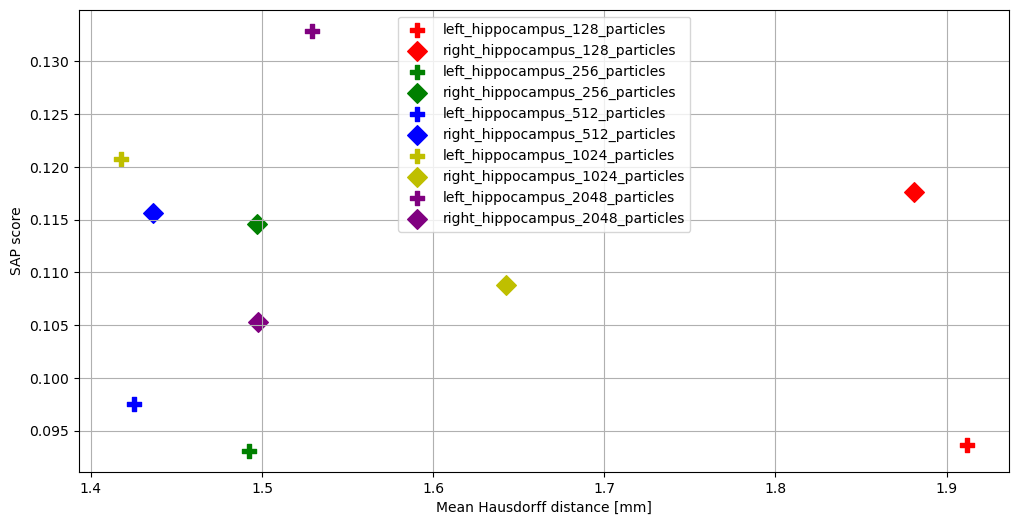

In [17]:
plt.figure(figsize=(12,6))

markersize = 100

plt.scatter(mean_dist_left_128, sap_score_left_128, markersize, marker="P", c="r", label="left_hippocampus_128_particles")
plt.scatter(mean_dist_right_128, sap_score_right_128, markersize, marker="D", c="r", label="right_hippocampus_128_particles")
plt.scatter(mean_dist_left_256, sap_score_left_256, markersize, marker="P", c="g", label="left_hippocampus_256_particles")
plt.scatter(mean_dist_right_256, sap_score_right_256, markersize, marker="D", c="g", label="right_hippocampus_256_particles")
plt.scatter(mean_dist_left_512, sap_score_left_512, markersize, marker="P", c="b", label="left_hippocampus_512_particles")
plt.scatter(mean_dist_right_512, sap_score_right_512, markersize, marker="D", c="b", label="right_hippocampus_512_particles")
plt.scatter(mean_dist_left_1024, sap_score_left_1024, markersize, marker="P", c="y", label="left_hippocampus_1024_particles")
plt.scatter(mean_dist_right_1024, sap_score_right_1024, markersize, marker="D", c="y", label="right_hippocampus_1024_particles")
plt.scatter(mean_dist_left_2048, sap_score_left_2048, markersize, marker="P", c="purple", label="left_hippocampus_2048_particles")
plt.scatter(mean_dist_right_2048, sap_score_right_2048, markersize, marker="D", c="purple", label="right_hippocampus_2048_particles")


plt.xlabel("Mean Hausdorff distance [mm]")
plt.ylabel("SAP score")

plt.legend()
plt.grid(True)
plt.show()

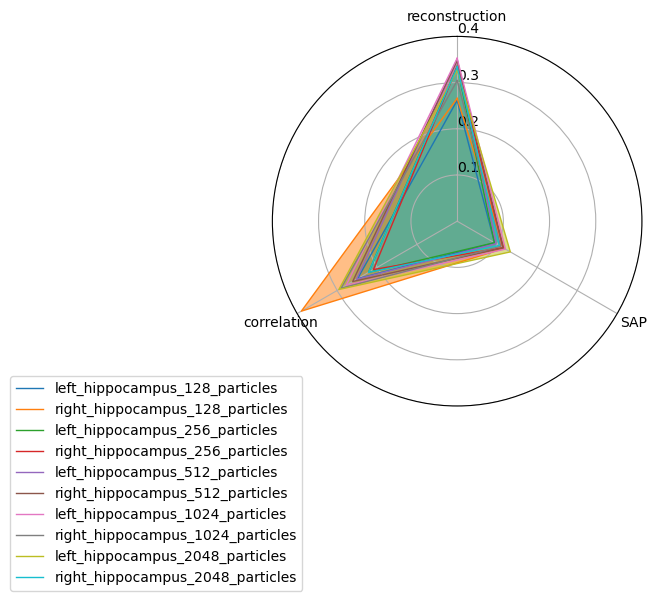

In [110]:
from math import pi

recon_scale_factor = 2

# Set data
df = pd.DataFrame({
'group': ['left_hippocampus_128_particles','right_hippocampus_128_particles',
          'left_hippocampus_256_particles','right_hippocampus_256_particles',
          'left_hippocampus_512_particles','right_hippocampus_512_particles',
          'left_hippocampus_1024_particles','right_hippocampus_1024_particles',
          'left_hippocampus_2048_particles','right_hippocampus_2048_particles',],
'reconstruction': [1/(mean_dist_left_128*recon_scale_factor), 1/(mean_dist_right_128*recon_scale_factor), 
                   1/(mean_dist_left_256*recon_scale_factor), 1/(mean_dist_right_256*recon_scale_factor),
                   1/(mean_dist_left_512*recon_scale_factor), 1/(mean_dist_right_512*recon_scale_factor),
                   1/(mean_dist_left_1024*recon_scale_factor), 1/(mean_dist_right_1024*recon_scale_factor),
                   1/(mean_dist_left_2048*recon_scale_factor), 1/(mean_dist_right_2048*recon_scale_factor)],
    
'SAP': [sap_score_left_128, sap_score_right_128,
        sap_score_left_256, sap_score_right_256,
        sap_score_left_512, sap_score_right_512,
        sap_score_left_1024, sap_score_right_1024,
        sap_score_left_2048, sap_score_right_2048],
    
'correlation': [corr_left_128, corr_right_128,
                corr_left_256, corr_right_256,
                corr_left_512, corr_right_512,
                corr_left_1024, corr_right_1024,
                corr_left_2048, corr_right_2048]
})
 
# ------- PART 1: Create background
 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.1,0.2,0.3,0.4], ["0.1","0.2","0.3","0.4"], color="black", size=10)
plt.ylim(0,0.4)
 

# ------- PART 2: Add plots

for i in range(len(df.group)):
    values=df.loc[i].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=df.group.to_list()[i])
    ax.fill(angles, values, alpha=0.5)

# # Ind1
# values=df.loc[0].drop('group').values.flatten().tolist()
# values += values[:1]
# ax.plot(angles, values, linewidth=1, linestyle='solid', label="group A")
# ax.fill(angles, values, 'b', alpha=0.1)
 
# # Ind2
# values=df.loc[1].drop('group').values.flatten().tolist()
# values += values[:1]
# ax.plot(angles, values, linewidth=1, linestyle='solid', label="group B")
# ax.fill(angles, values, 'r', alpha=0.1
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Show the graph
plt.show()
